# Spatiotemporal CNN-RNN Proxy Model for CO2 Monitoring
### Misael M. Morales, The University of Texas at Austin
***

In [1]:
from utils import *
check_tensorflow_gpu()

proxy = SpatiotemporalCO2()

c:\Users\Misael Morales\miniconda3\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\Misael Morales\miniconda3\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you 

... Checking Tensorflow Version ...
Tensorflow built with CUDA? True
TF: 2.10.0 | CUDA: 64_112 | cuDNN: 64_8
# GPU available: 1 (NVIDIA GeForce RTX 3080)
--------------------------------------


In [2]:
proxy.load_data()
proxy.process_data()

... Loading Full Dataset ...
X: (1000, 64, 64, 4) | y: (1000, 60, 64, 64, 2)
Data Augmentation Done!    - n_samples=2,000
MinMax Normalization Done! - [0.0, 1.0]
Train - X: (1500, 64, 64, 4) | y: (1500, 11, 64, 64, 2)
Test  - X: (500, 64, 64, 4)  | y: (500, 11, 64, 64, 2)


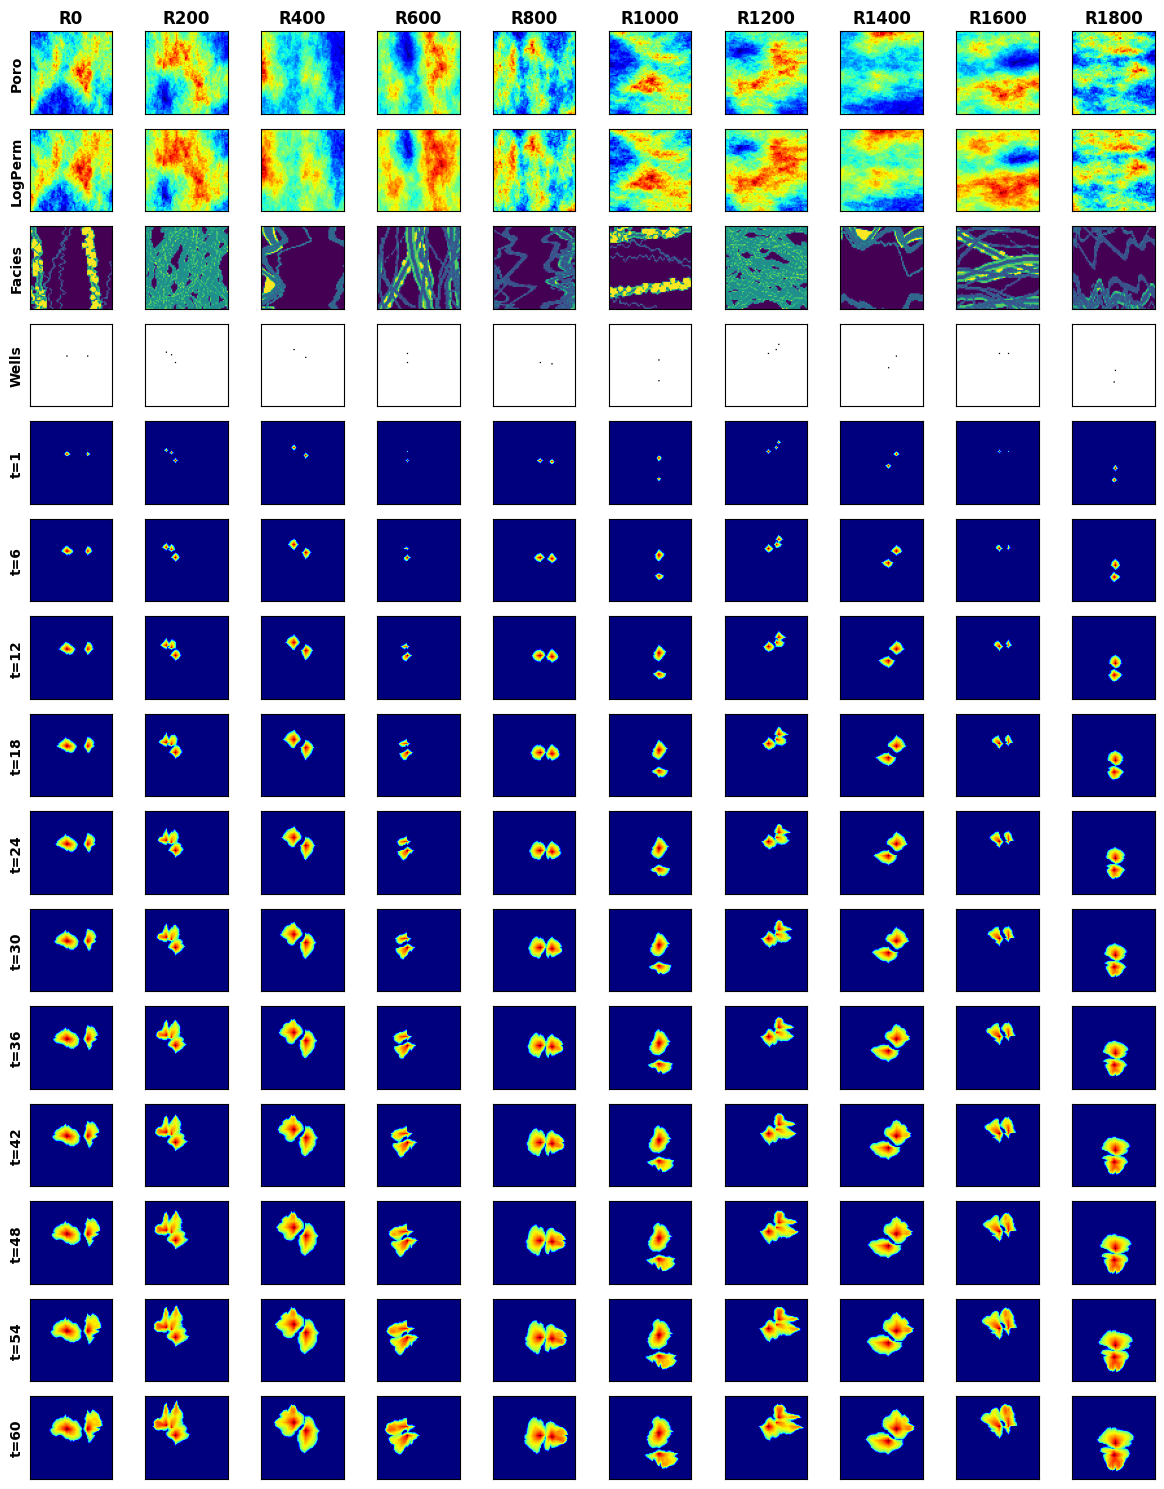

In [3]:
proxy.plot_data()
#proxy.plot_features(); proxy.plot_targets()

In [4]:
proxy.make_model()

In [5]:
#proxy.training()
proxy.model.load_weights('model_weights.h5')

In [6]:
proxy.predictions()

16/16 [==============================] - 3s 223ms/step
Train pred: (1500, 11, 64, 64, 2) | Test pred: (500, 11, 64, 64, 2)
MSE  | Train: 9.21e-04, Test: 9.70e-04
SSIM | Train: 96.97, Test: 96.91


47/47 [==============================] - 1s 7ms/step
Latent shape: (1500, 8, 8, 256)


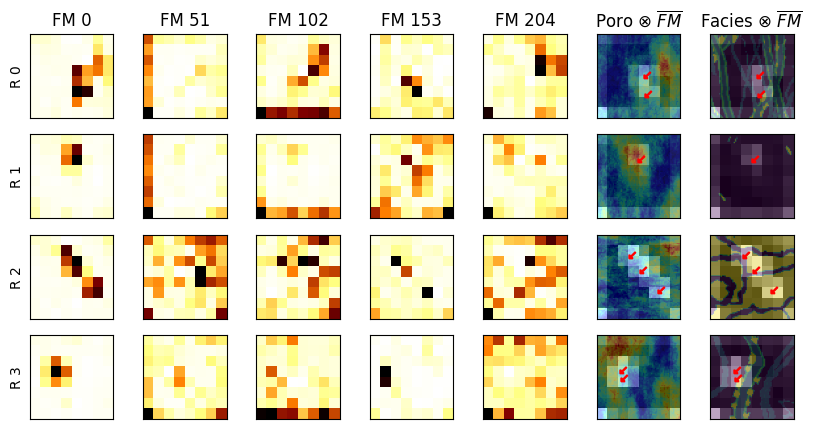

In [7]:
proxy.latent_space()
#proxy.feature_map_animation

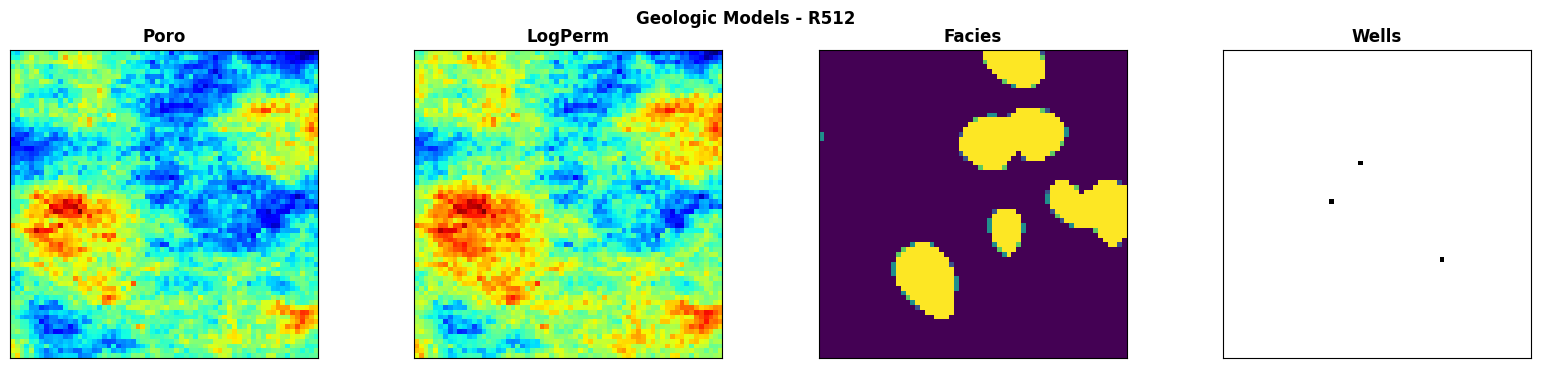

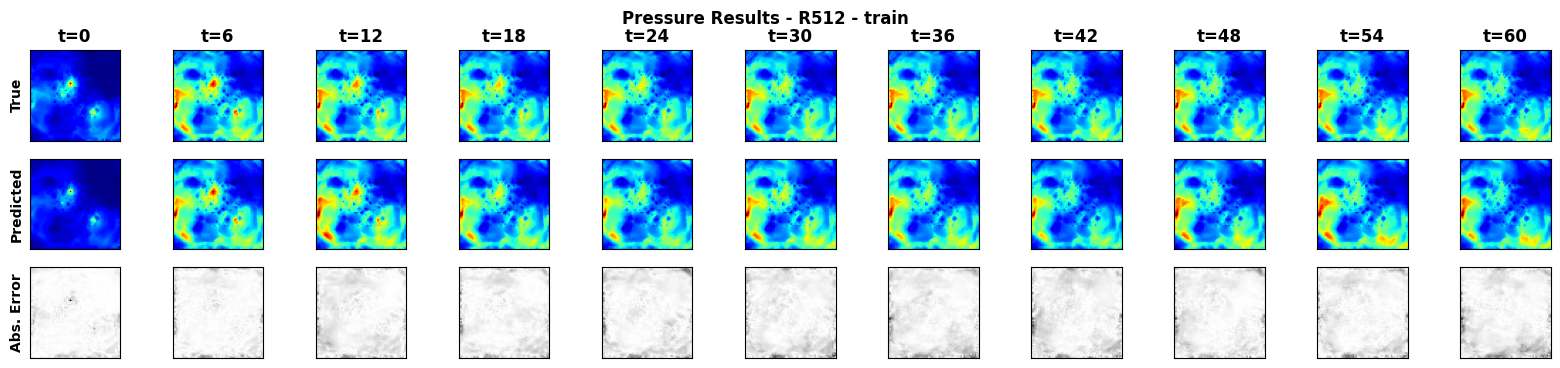

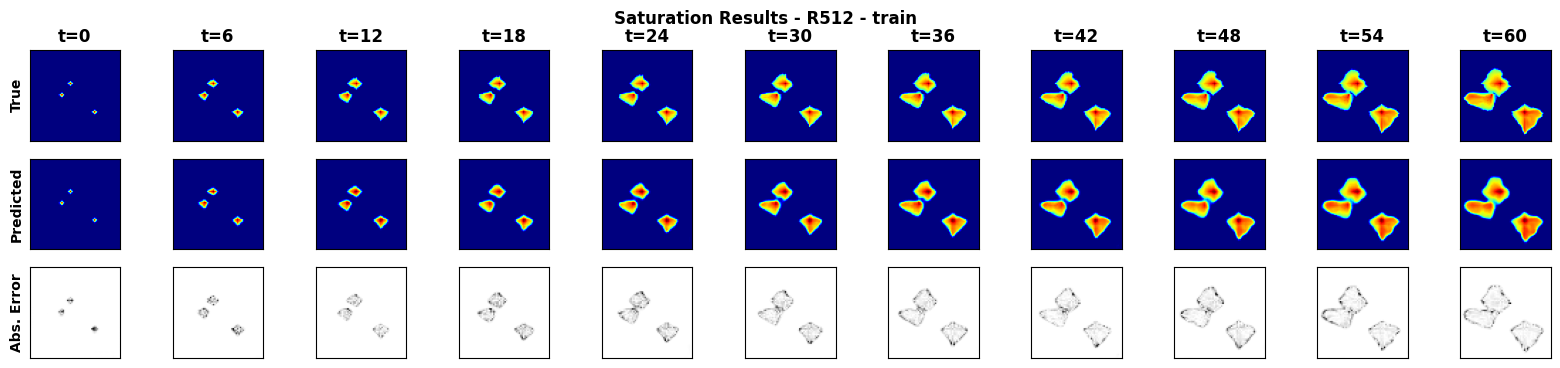

In [8]:
proxy.plot_single_results(512, 'train')

Train - Mean CO2 Injected: True: 4744.80 | Pred: 4794.71
Test  - Mean CO2 Injected: True: 4848.08 | Pred: 4860.85


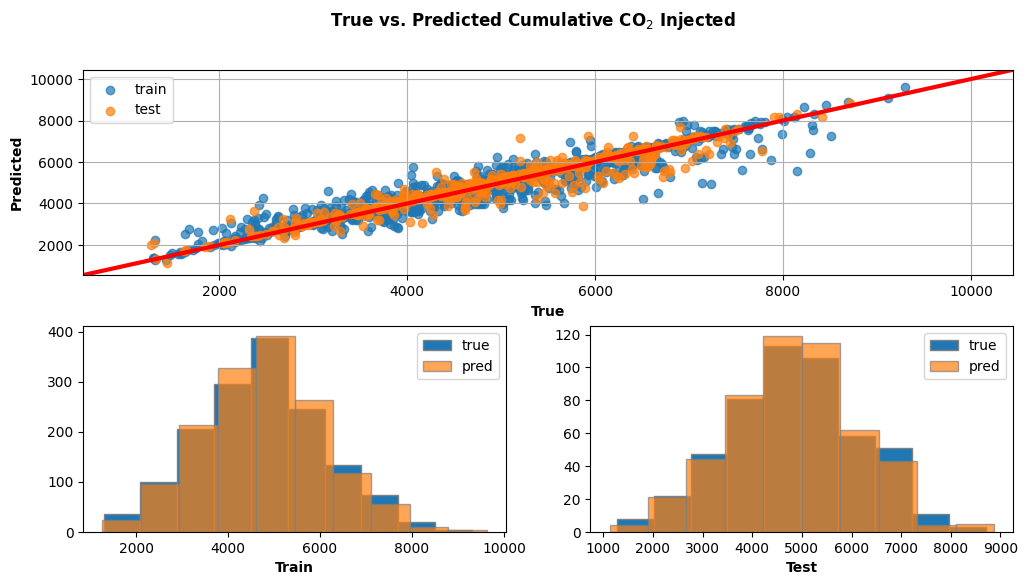

In [9]:
proxy.cumulative_co2()

***
# END